# Часть 1: получение и анализ данных



#### Библиотеки

In [1]:
import pandas as pd
import numpy as np
import math
import random

import yfinance as yf

import datetime
from datetime import datetime

from copy import copy, deepcopy

import sys
import warnings
warnings.filterwarnings("ignore")

In [2]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
import scipy.stats as stats
from scipy.stats import norm, skewnorm, gennorm, t, nct, genpareto, genextreme, genhyperbolic, exponpow, chi2, ncx2
from scipy.stats import skew, kurtosis, goodness_of_fit

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

In [4]:
from google.colab import drive
drive.mount('/content/drive')

folder = '/content/drive/MyDrive/Kagan_VKR/data/'
name_for_save='price_data.xlsx'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# модуль для анализа активов, реализованный в рамках ВКР

from data_analysis import FinancialInstrument

# Сбор данных

In [6]:
# Если необходимые данные уже загружены
df_price = pd.read_excel(folder+name_for_save)
df_price.set_index('Date', inplace=True)

**Выбранные показатели:**
- индекс МосБиржи (IMOEX)\
https://investfunds.ru/indexes/216/
- индекс Bloomberg Brent Crude (BCOMCO)\
https://www.investing.com/indices/bbg-brent-crude-historical-data
- курс доллара USD/RUB
- акции Газпрома\
https://www.finam.ru/quote/moex/gazp/export/

In [ ]:
# Выбор периода

start_date = '2012-01-01'
end_date = '2023-12-31'

In [ ]:
# Выбор тикеров
tickers_list = ['EURRUB=X', 'USDRUB=X']

rename_columns = {'EURRUB=X':'EUR/RUB', 'USDRUB=X':'USD/RUB',
        'VTBR.ME':'ВТБ', 'YNDX.ME':'Яндекс', 'AFLT.ME':'Аэрофлот', 'MTSS.ME':'МТС', 'FIVE.ME':'X5 Group', 'PIKK.ME':'ПИК',
        'LKOH.ME':'Лукойл', 'ROSN.ME':'Роснефть', 'GMKN.ME':'Норникель',
        'SBER':'Сбербанк', 'GAZP':'Газпром', 'Brent Crude':'BCOMCO'}

price_column = 'Close'

In [ ]:
df_price_yf = yf.download(tickers = tickers_list,
                        start = start_date,
                        end = end_date,
                        interval = '1d')[price_column]

df_price_yf.index = pd.to_datetime(df_price_yf.index, format='%Y-%m-%d')
df_price_yf.sort_index(inplace=True)

[*********************100%%**********************]  2 of 2 completed


In [ ]:
name1 = 'Bloomberg Brent Crude Historical Data.csv'
df_brent = pd.read_csv(folder + name1)[['Date', 'Brent Crude']]
df_brent['Date'] = pd.to_datetime(df_brent['Date'], format="%m/%d/%Y")
df_brent.set_index('Date', inplace=True)

In [ ]:
name2 = 'Индекс МосБиржи.xlsx'
df_imoex = pd.read_excel(folder + name2)
df_imoex['Date'] = pd.to_datetime(df_imoex['Date'], format='%Y-%m-%d')
df_imoex.set_index('Date', inplace=True)

In [ ]:
name3 = 'Gazprom_2012_2023.xlsx'
df_gazp = pd.read_excel(folder + name3)
df_gazp['Date'] = pd.to_datetime(df_gazp['Date'], format='%Y%m%d')
df_gazp.set_index('Date', inplace=True)

In [ ]:
df_price_0 = df_brent.merge(df_imoex, on='Date', how='outer')
df_price_1 = df_price_0.merge(df_gazp, on='Date', how='outer')

In [ ]:
df_price = df_price_yf.merge(df_price_1, on='Date', how='outer')
df_price.rename(columns=rename_columns, inplace=True)
df_price.sort_index(inplace=True)

In [ ]:
# Кол-во пропусков

df_price.isnull().sum()

EUR/RUB    263
USD/RUB    265
BCOMCO     369
IMOEX      379
Газпром    208
dtype: int64

In [ ]:
#Сохранение данных

df_price.to_excel(folder+name_for_save)

In [7]:
df_returns = df_price.pct_change()

### Визуализация

**Цены показателей в динамике**

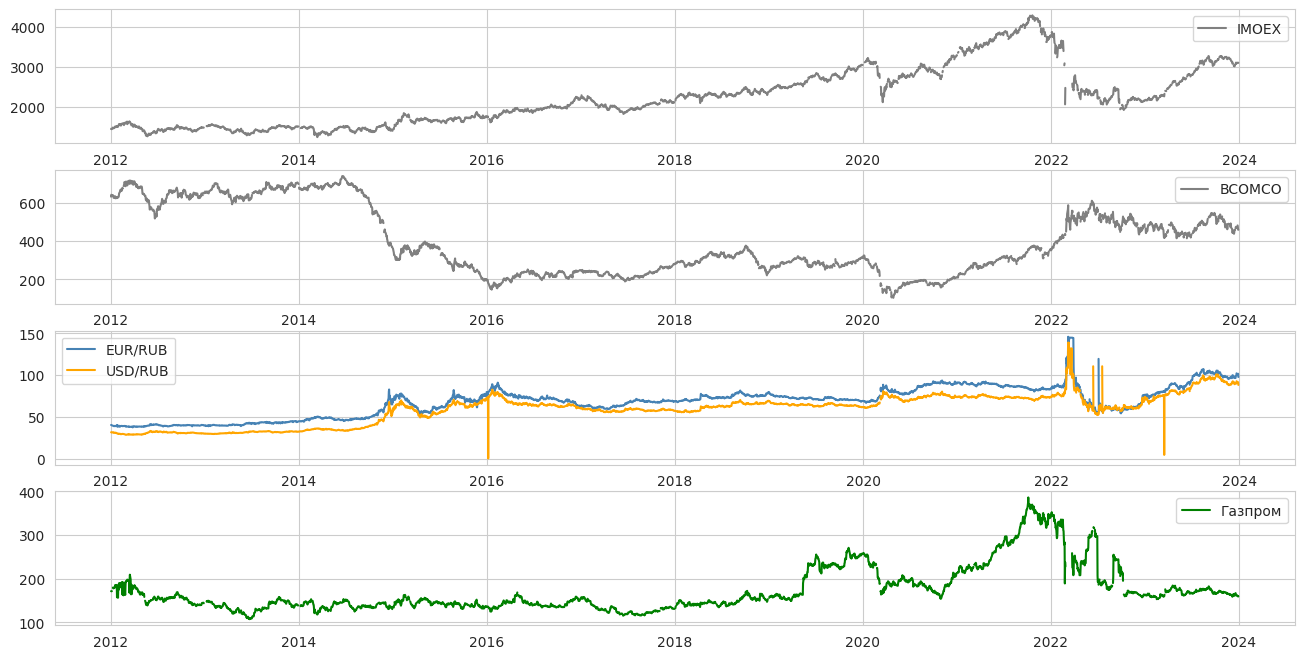

In [9]:
fig, axs = plt.subplots(4, 1, figsize = (16, 8))
axs[0].plot(df_price['IMOEX'], label = 'IMOEX', color = 'grey')
axs[0].legend()
axs[1].plot(df_price['BCOMCO'], label = 'BCOMCO', color='grey')
axs[1].legend()
axs[2].plot(df_price['EUR_RUB'], label = 'EUR/RUB', color='steelblue')
axs[2].plot(df_price['USD_RUB'], label = 'USD/RUB', color='orange')
axs[2].legend()
axs[3].plot(df_price['Газпром'], label = 'Газпром', color='green')
axs[3].legend()
plt.show()

**Доходности**

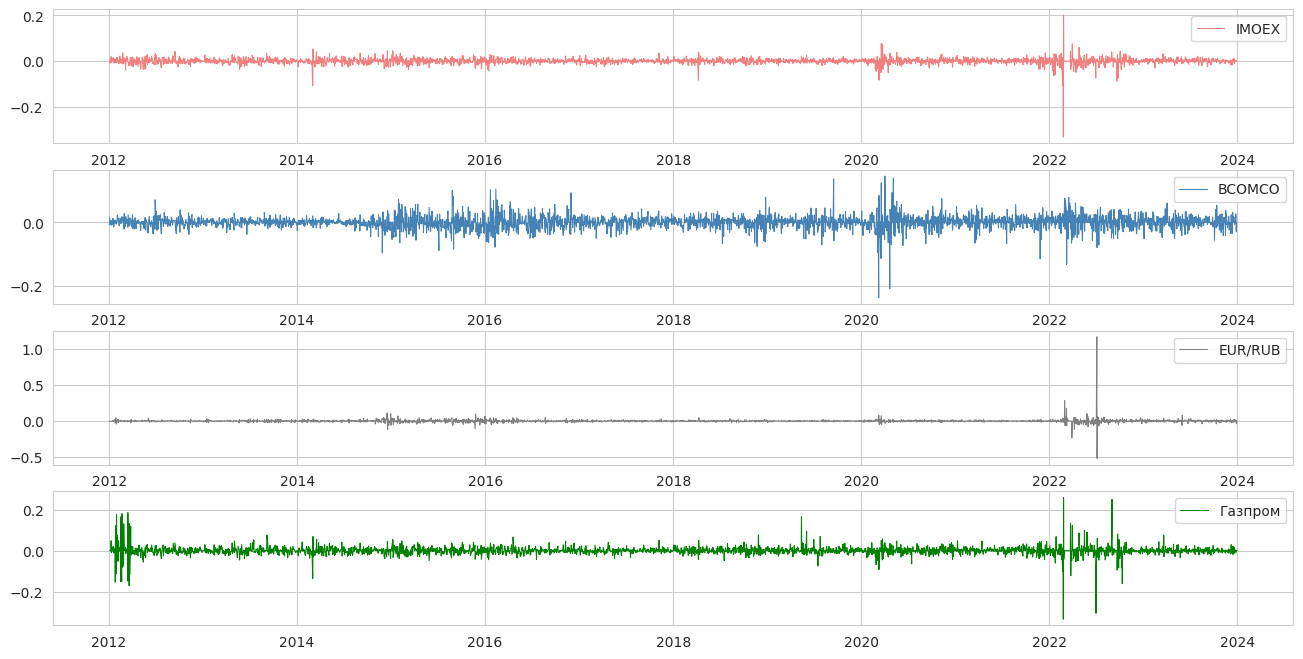

In [10]:
fig, axs = plt.subplots(4, 1, figsize = (16, 8))
axs[0].plot(df_returns['IMOEX'], label = 'IMOEX', color = 'lightcoral', linewidth = 0.75)
axs[0].legend()
axs[1].plot(df_returns['BCOMCO'], label = 'BCOMCO', color='steelblue', linewidth = 0.75)
axs[1].legend()
axs[2].plot(df_returns['EUR_RUB'], label = 'EUR/RUB', color='grey', linewidth = 0.75)
axs[2].legend()
axs[3].plot(df_returns['Газпром'], label = 'Газпром', color='green', linewidth = 0.75)
axs[3].legend()
plt.show()

### Корреляция

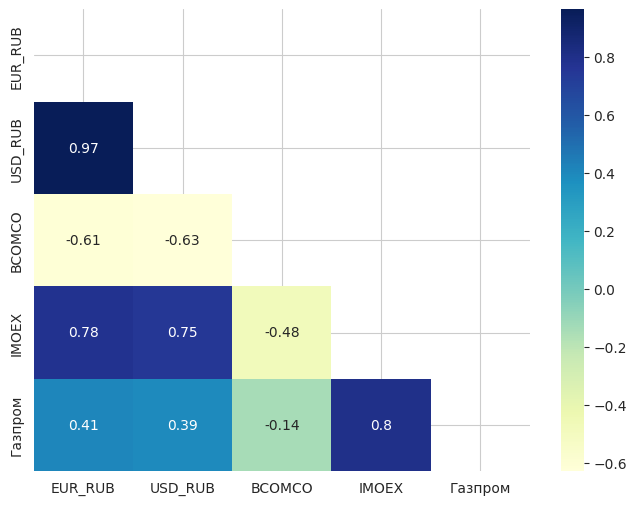

In [11]:
corr_matrix = df_price.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

fig, axs = plt.subplots(1, 1, figsize = (8, 6))
sns.heatmap(corr_matrix, mask=mask, cmap="YlGnBu", annot=True, ax=axs)
plt.show()

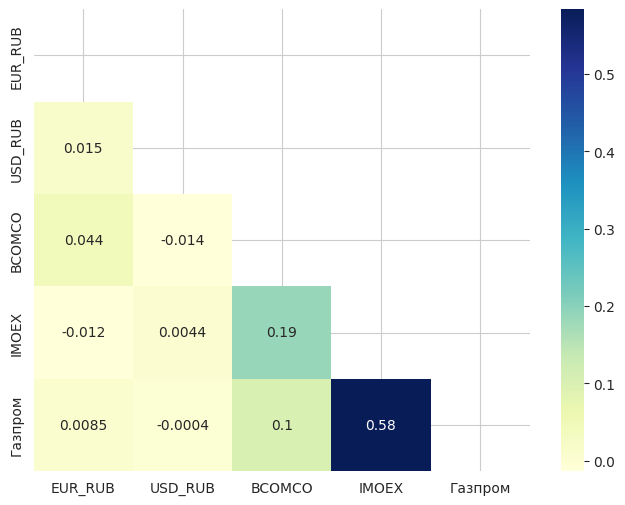

In [12]:
corr_matrix = df_returns.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

fig, axs = plt.subplots(1, 1, figsize = (8, 6))
sns.heatmap(corr_matrix, mask=mask, cmap="YlGnBu", annot=True, ax=axs)
plt.show()

# Анализ данных

### Индекс IMOEX

In [13]:
imoex = FinancialInstrument(df=df_price, name='IMOEX')

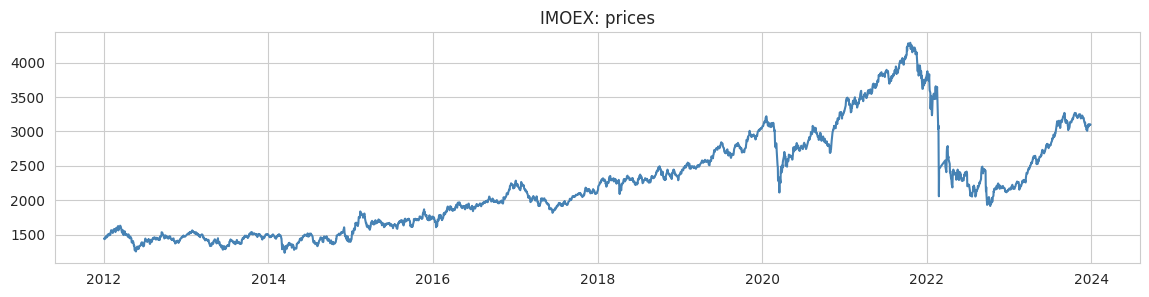

In [14]:
imoex.price_dynamics()

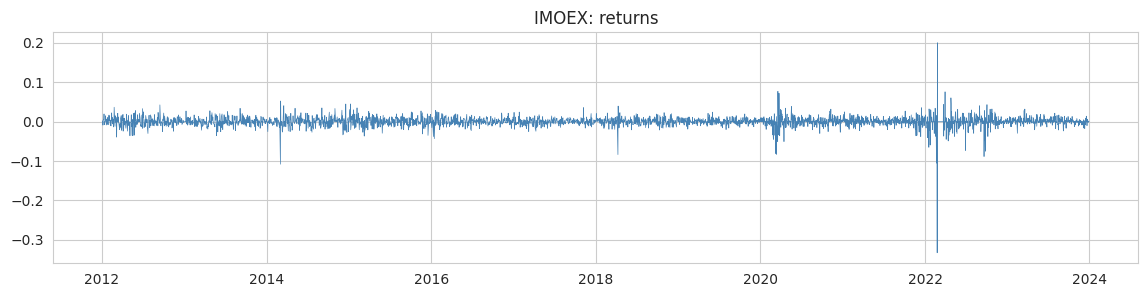

In [15]:
imoex.returns_dynamics()

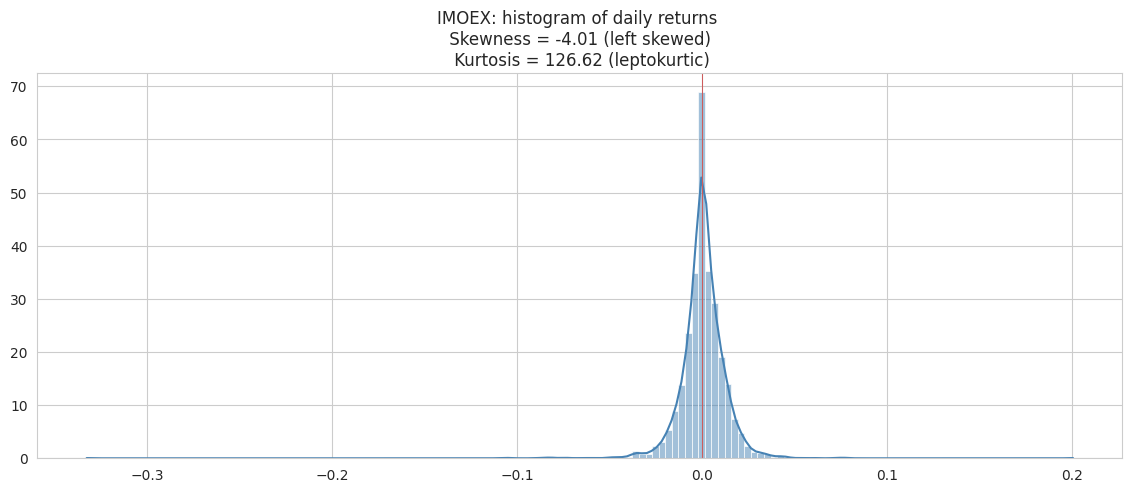

In [16]:
imoex.histogram(bins=150)

In [19]:
imoex.hill_estimator(m=10)

Hill estimator
Left tail index: 0.309
Right tail index: 0.382


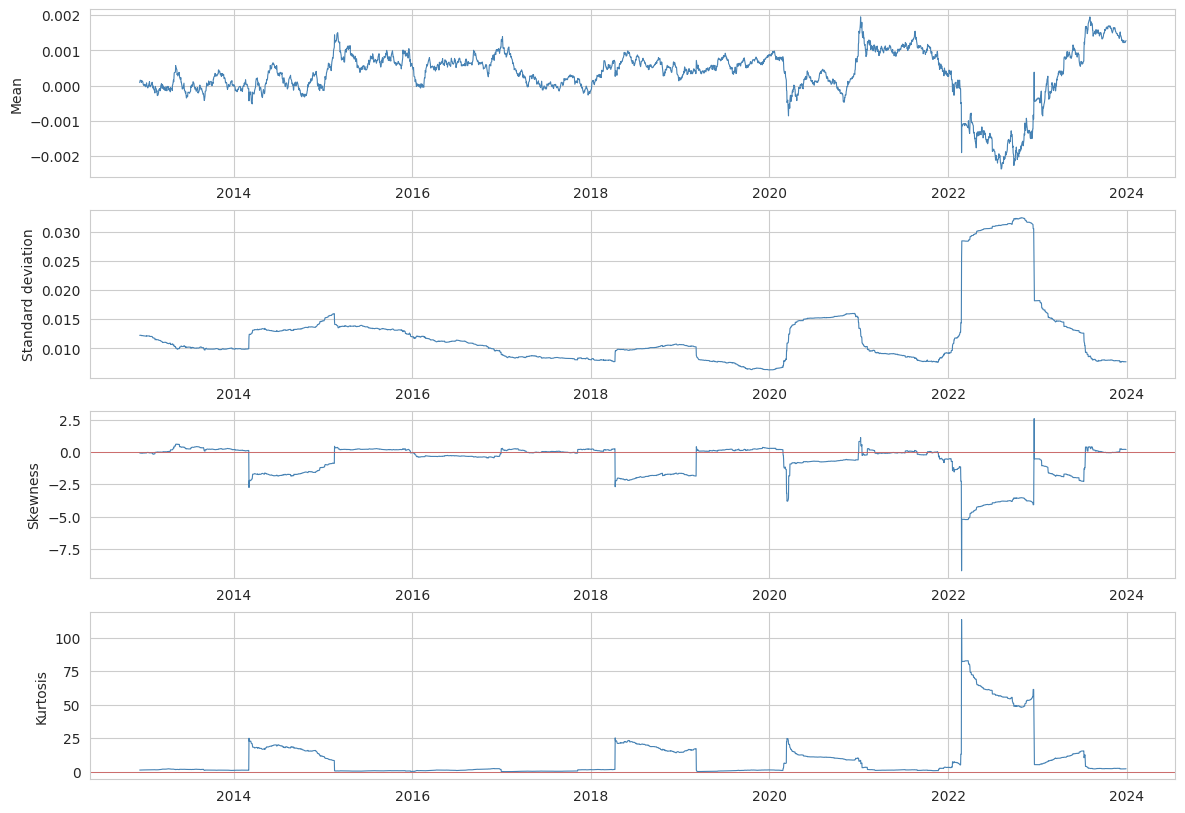

In [20]:
imoex.get_moving_dynamic(window_size=250)

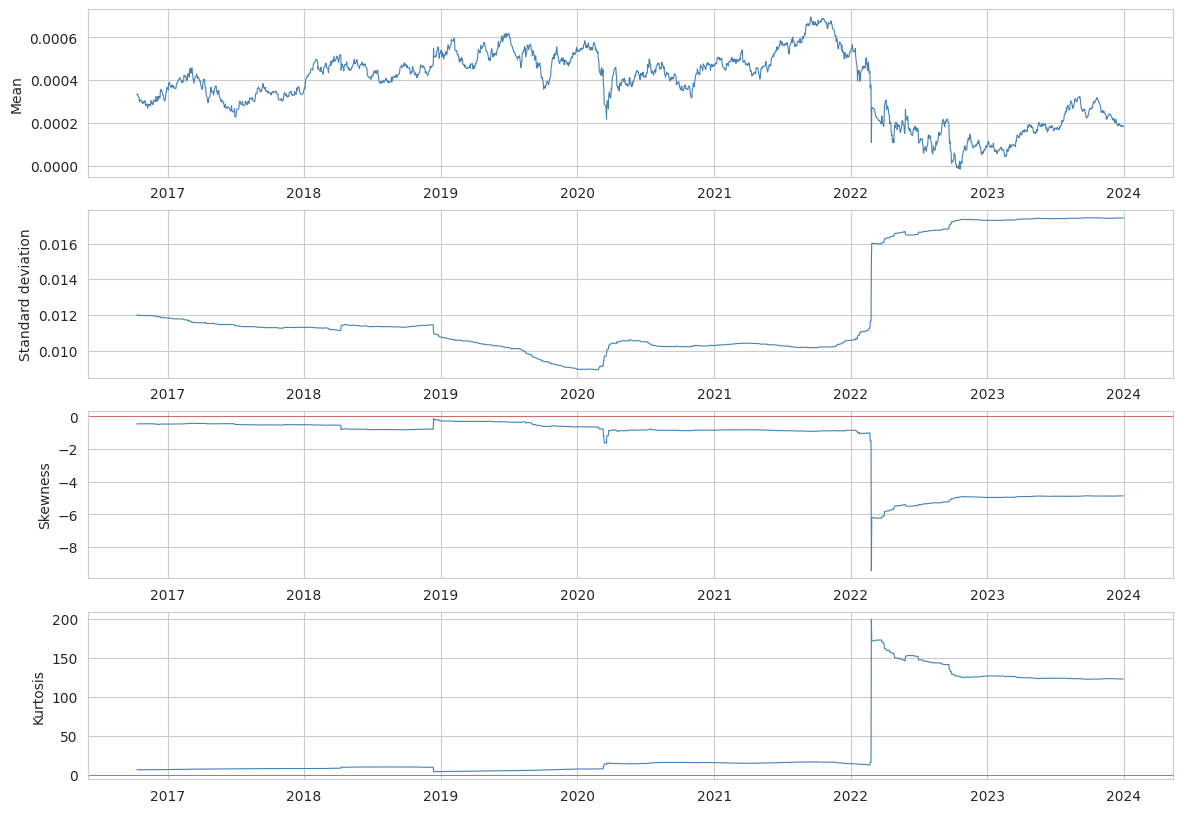

In [21]:
imoex.get_moving_dynamic(window_size=1250)

In [22]:
warnings.filterwarnings("ignore")

imoex.stationarity_test()

Stationarity test
ADF test: the series is stationary.
KPSS test: the series is stationary.


In [23]:
imoex.ljungbox_test()

Ljung-Box test 
         lb_stat     lb_pvalue comment
1     37.809219  7.801224e-10        
5     52.945446  3.451216e-10        
25    91.943012  1.375170e-09        
50   160.663795  1.541418e-13        
250  404.086618  2.268915e-09        


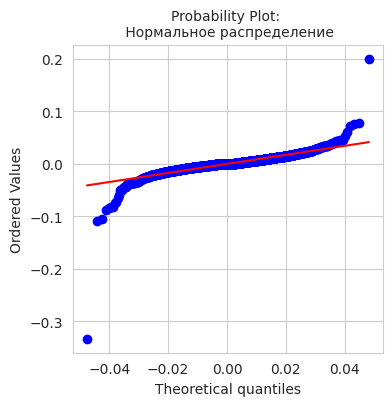

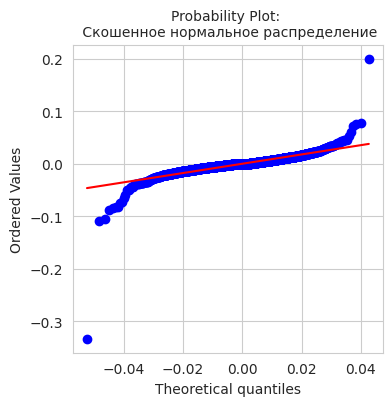

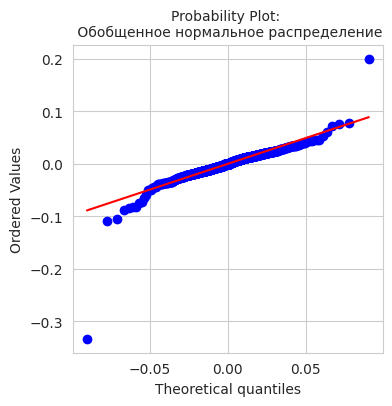

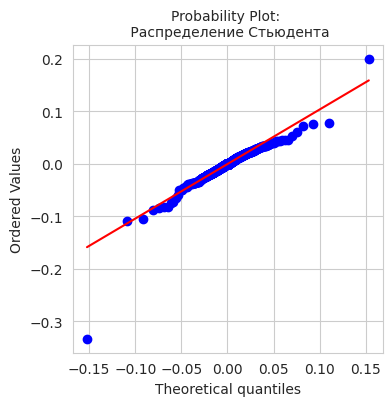

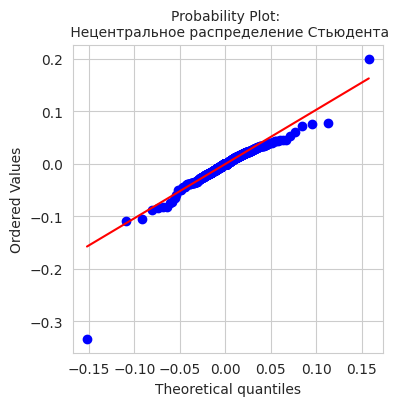

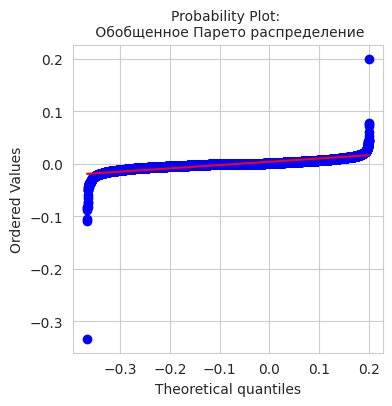

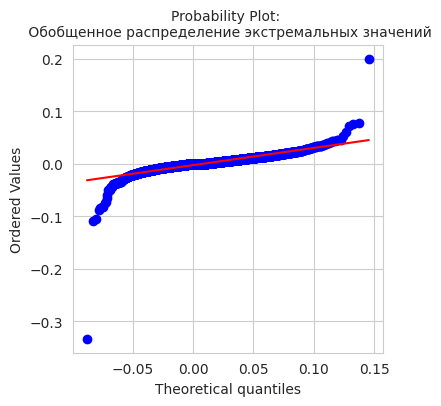

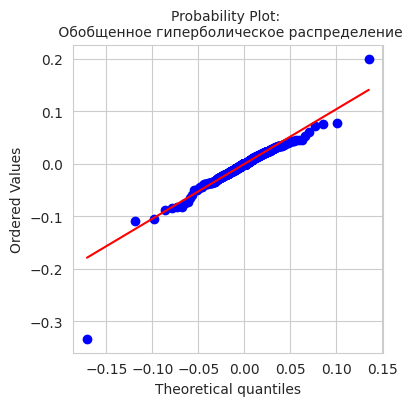

In [24]:
imoex.qq_plot()

In [ ]:
imoex.goodness_of_fit_test(dist_list=['norm', 'GGD', 't'])

Goodness-of-Fit test
Нормальное распределение: p_value = 0.0001


Обобщенное нормальное распределение: p_value = 0.0001


Распределение Стьюдента: p_value = 0.0014




### BCOMCO

In [25]:
stock_brent = FinancialInstrument(df=df_price, name='BCOMCO')

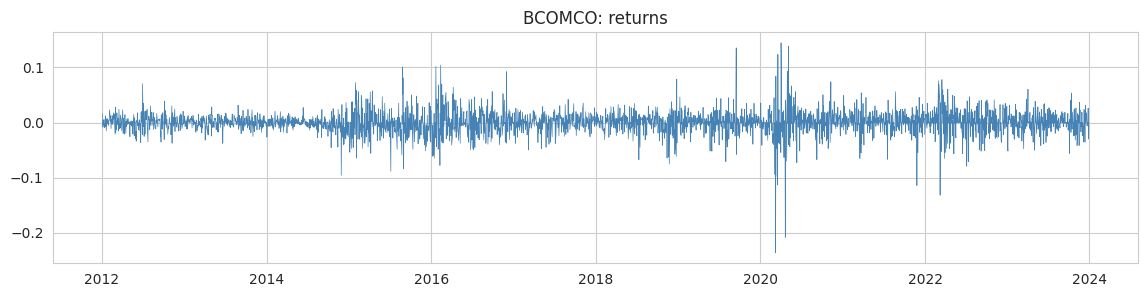

In [26]:
stock_brent.returns_dynamics()

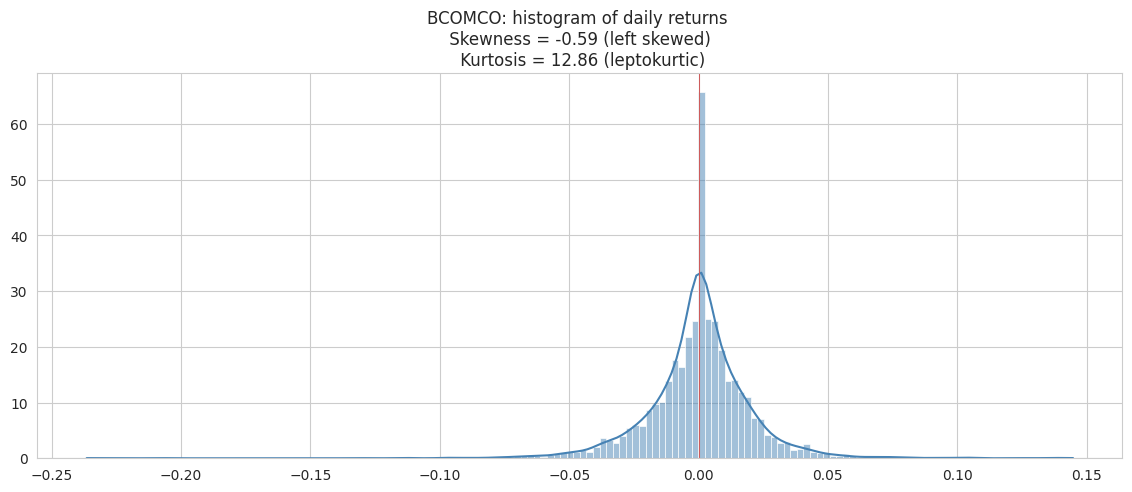

In [27]:
stock_brent.histogram(bins=150)

In [28]:
stock_brent.hill_estimator()

Hill estimator
Left tail index: 0.243
Right tail index: 0.355


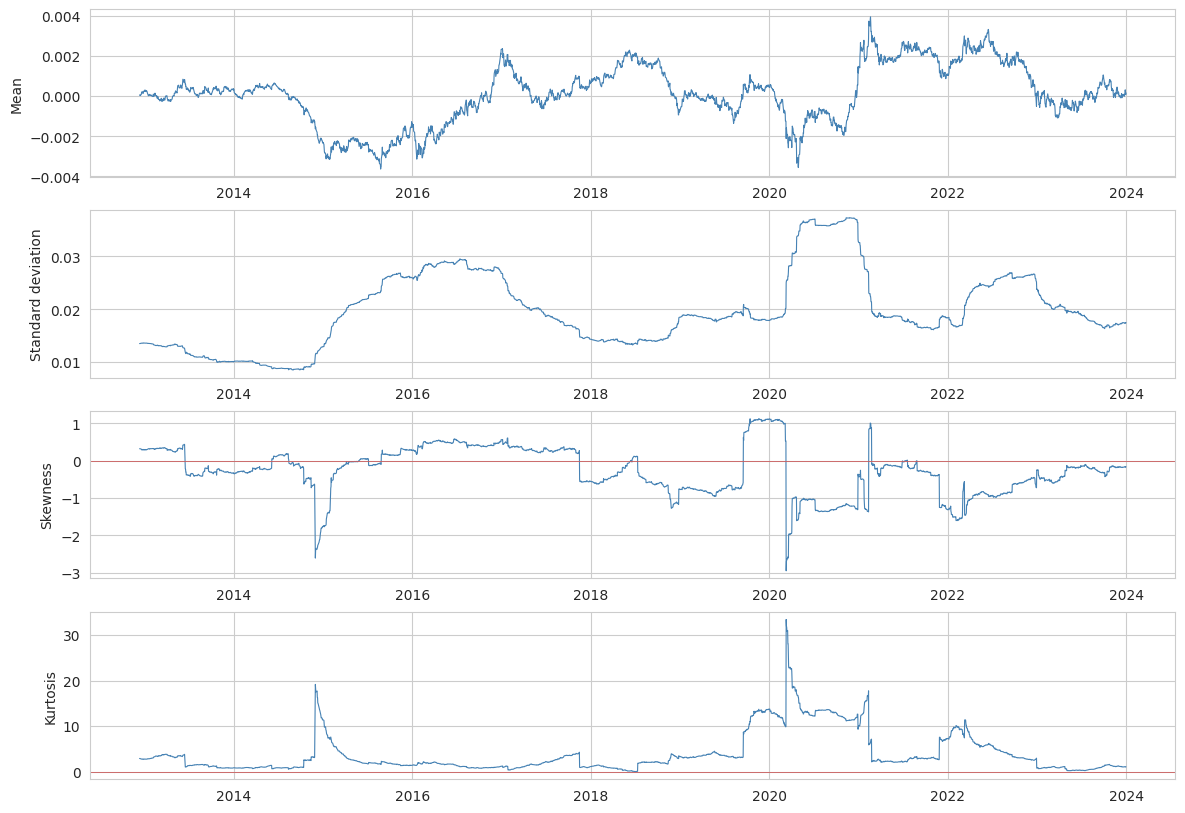

In [29]:
stock_brent.get_moving_dynamic()

In [30]:
stock_brent.stationarity_test()

Stationarity test
ADF test: the series is stationary.
KPSS test: the series is stationary.


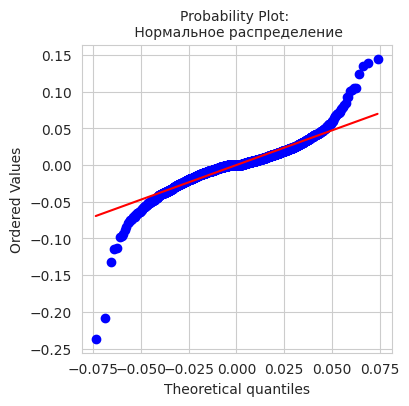

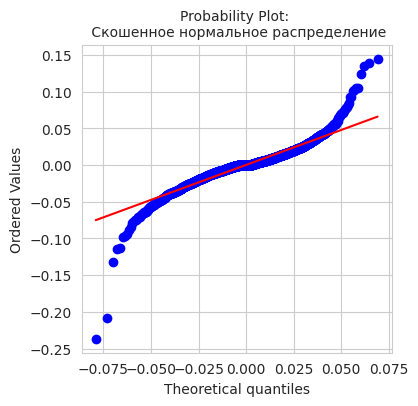

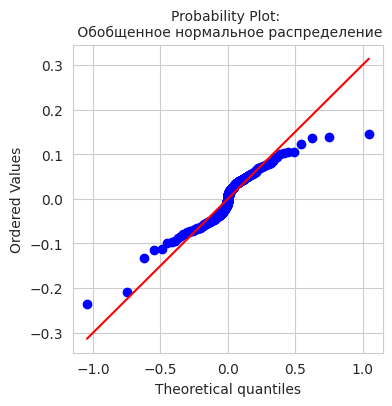

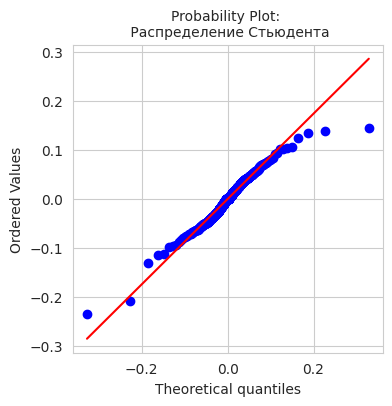

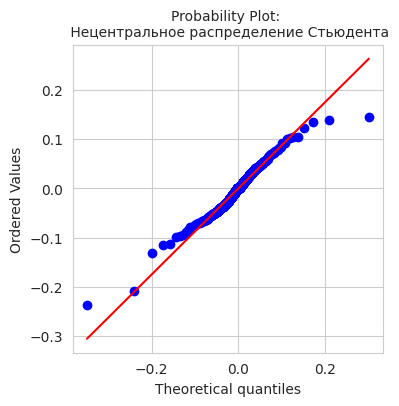

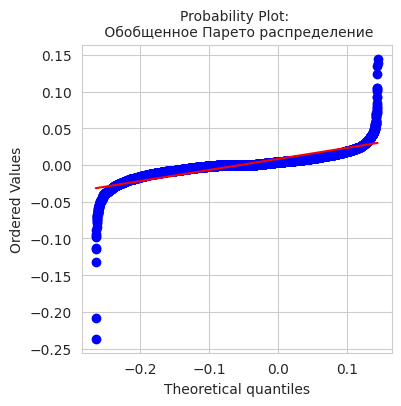

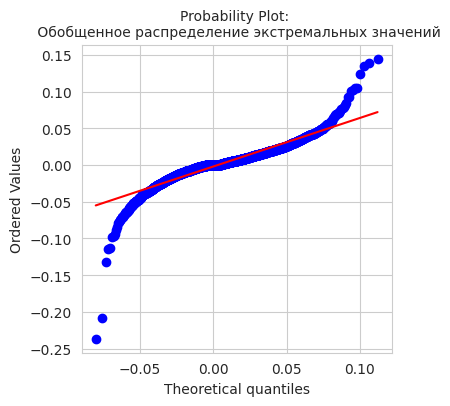

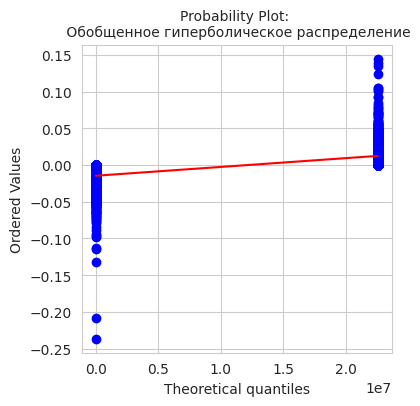

In [31]:
stock_brent.qq_plot()

### Курс доллара

In [35]:
dollar = FinancialInstrument(df=df_price, name='USD_RUB')

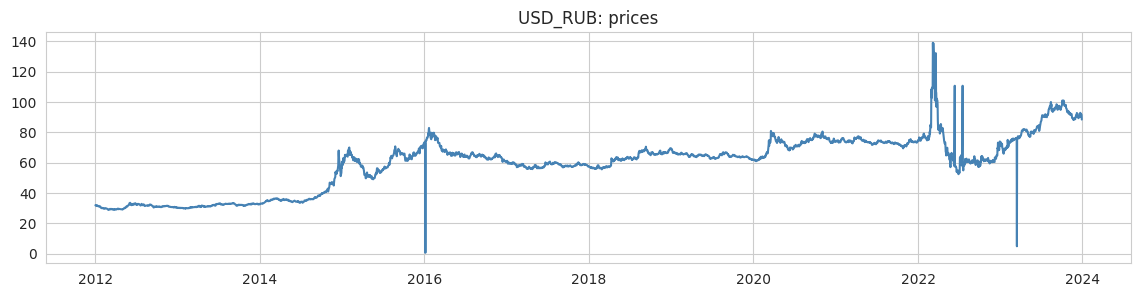

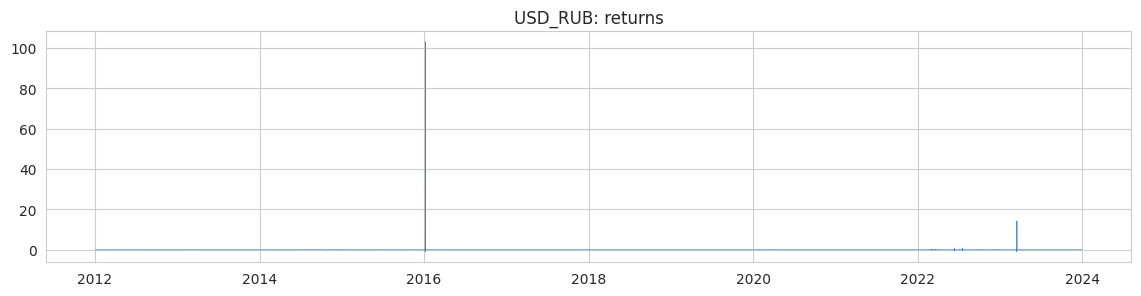

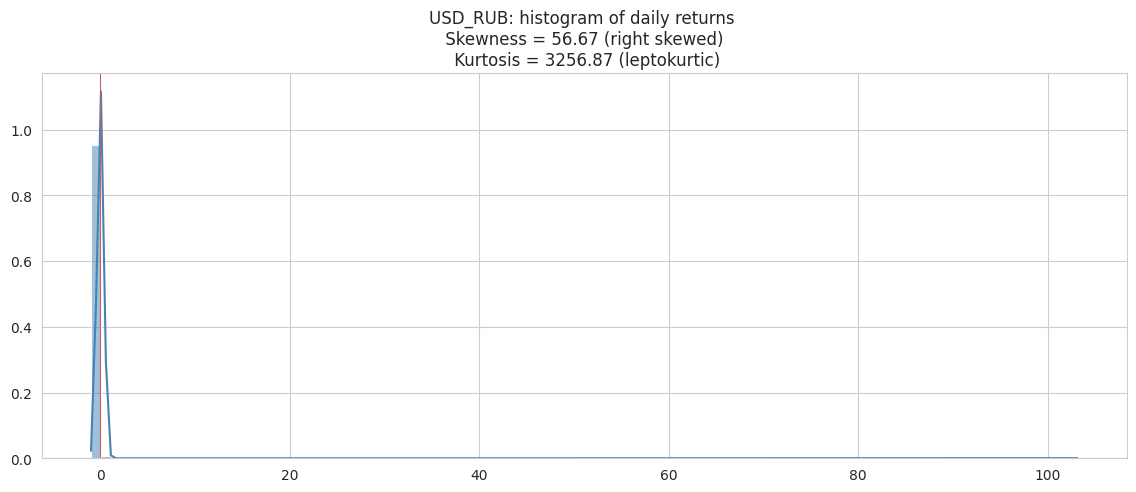

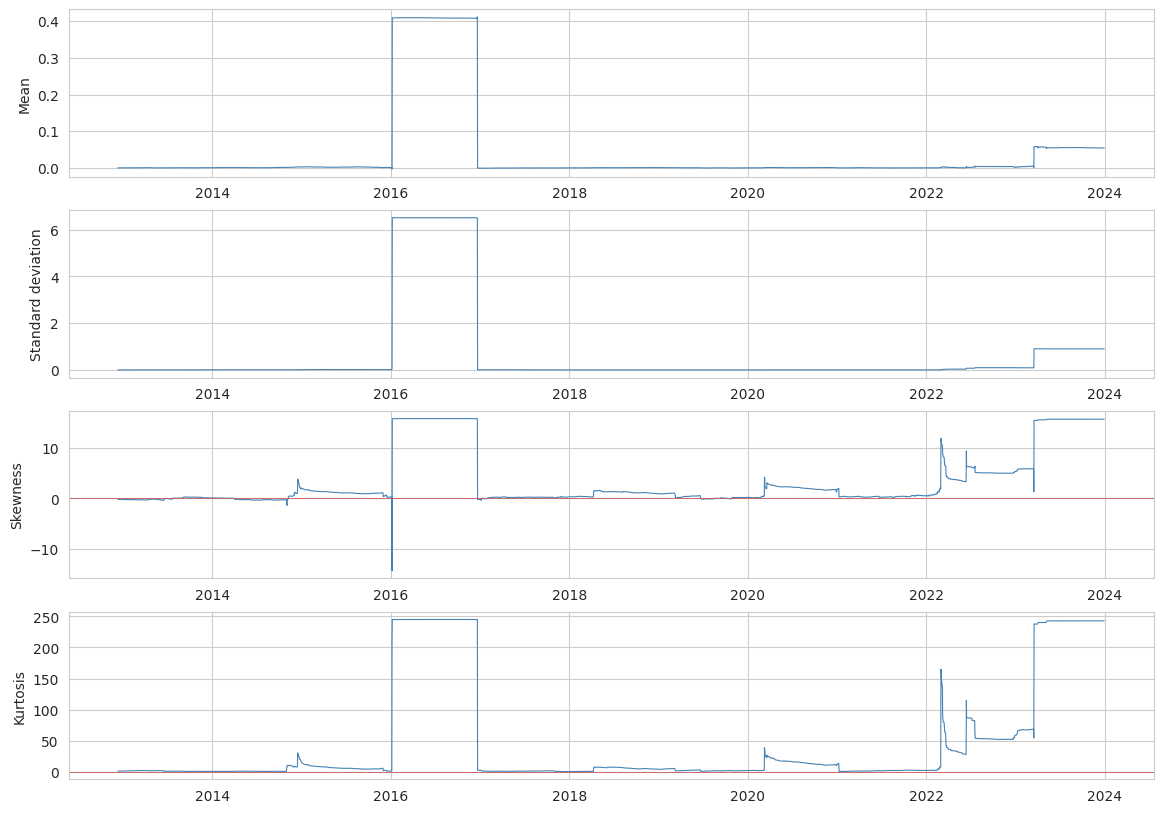

Hill estimator
Left tail index: 0.609
Right tail index: 1.109


Stationarity test
ADF test: the series is stationary.
KPSS test: the series is stationary.


Ljung-Box test 
       lb_stat  lb_pvalue         comment
1    0.418897   0.517488  p_value > 0.05
5    0.420142   0.994757  p_value > 0.05
25   0.432645   1.000000  p_value > 0.05
50   0.449181   1.000000  p_value > 0.05
250  0.595259   1.000000  p_value > 0.05




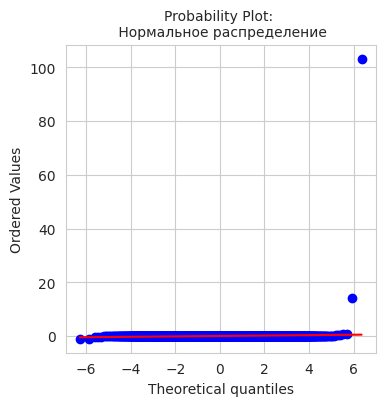

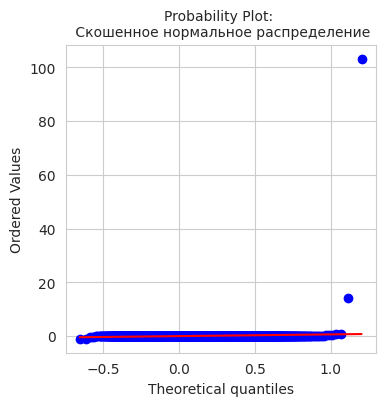

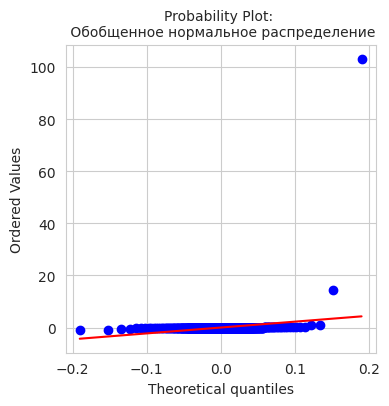

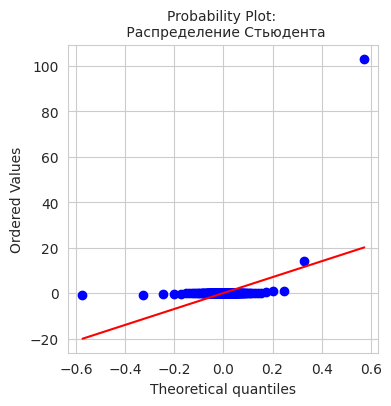

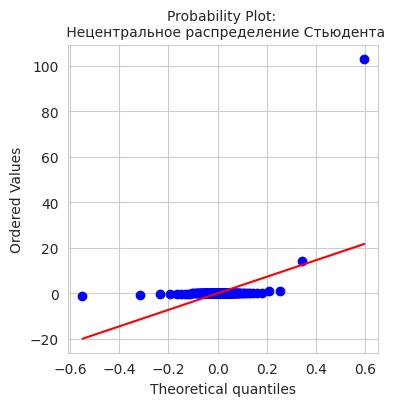

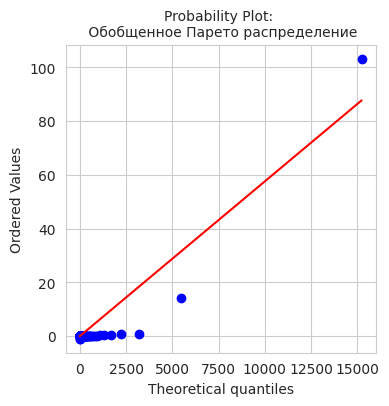

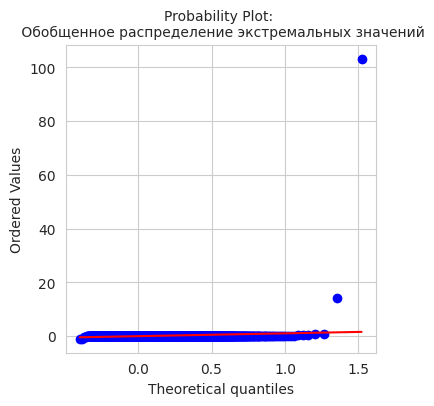

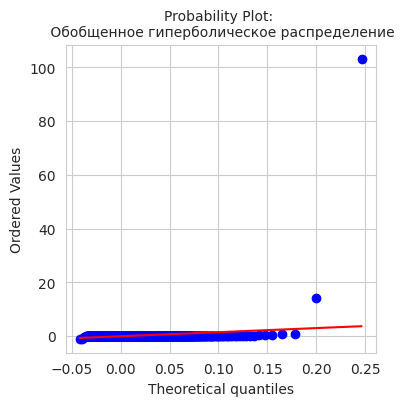

In [36]:
dollar.full_info()

### Курс евро

In [37]:
euro = FinancialInstrument(df=df_price, name='EUR_RUB')

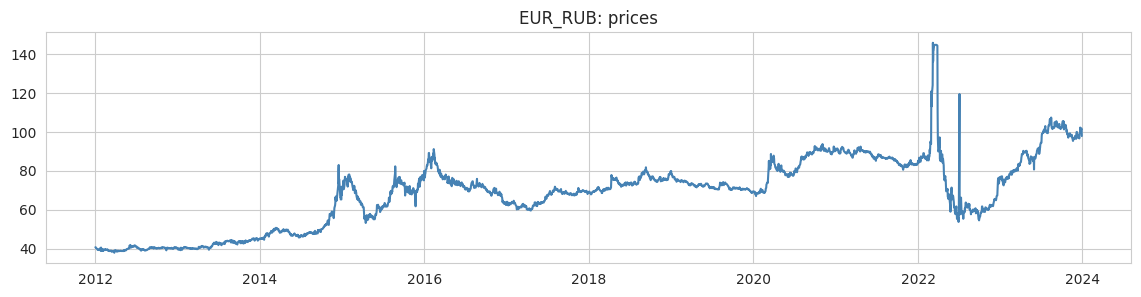

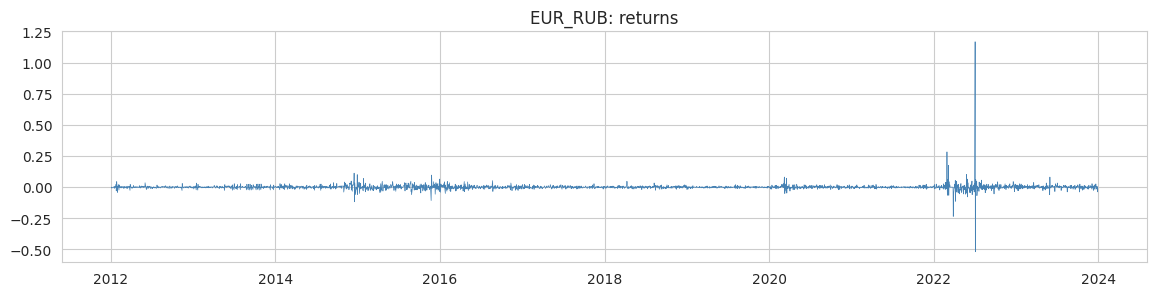

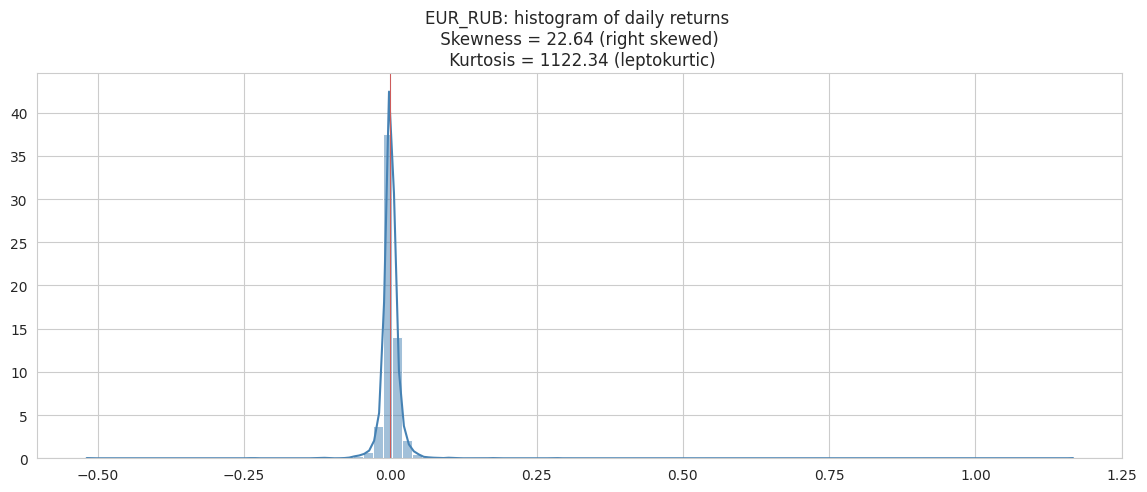

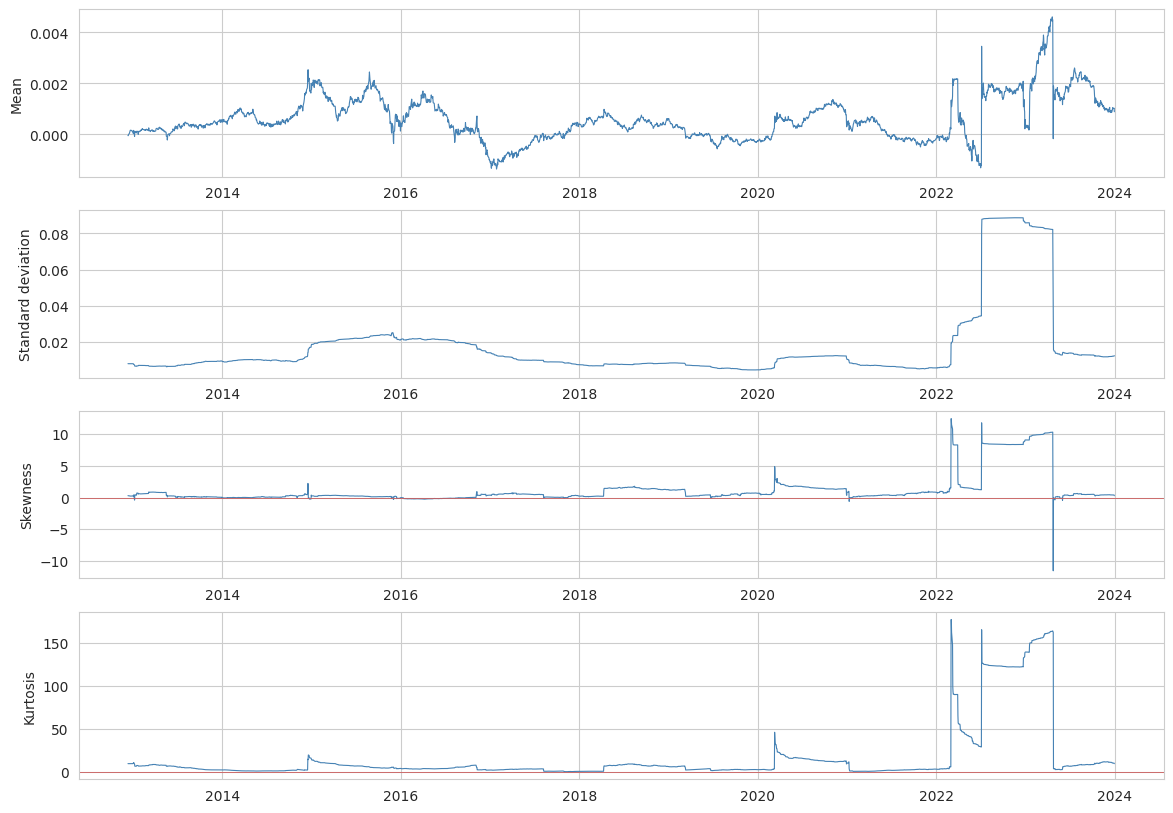

Hill estimator
Left tail index: 0.349
Right tail index: 0.528


Stationarity test
ADF test: the series is stationary.
KPSS test: the series is stationary.


Ljung-Box test 
         lb_stat     lb_pvalue comment
1    262.342633  5.295254e-59        
5    265.883672  2.142109e-55        
25   305.798956  4.118678e-50        
50   355.120442  1.382923e-47        
250  622.250387  1.110288e-33        




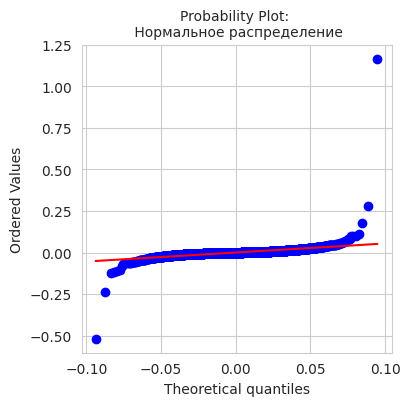

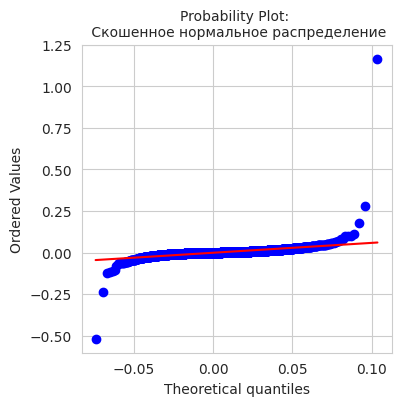

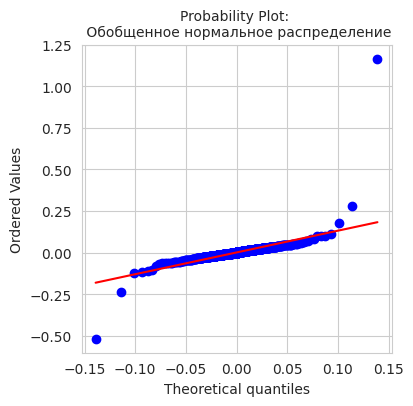

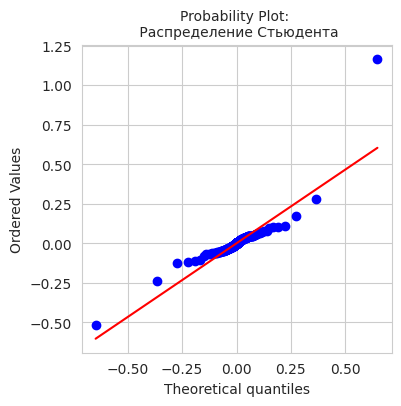

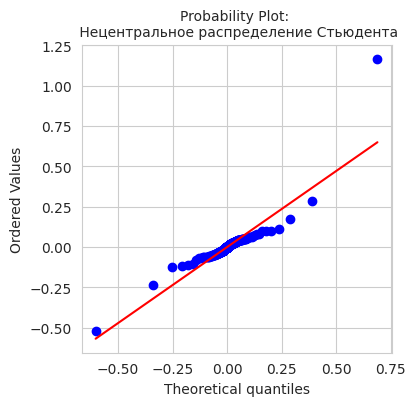

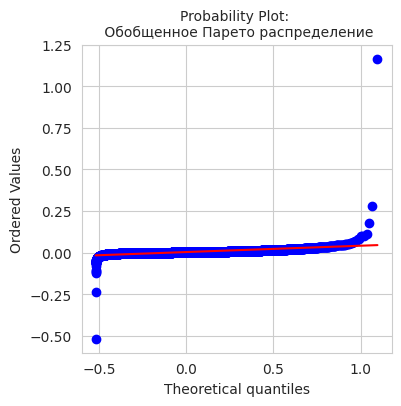

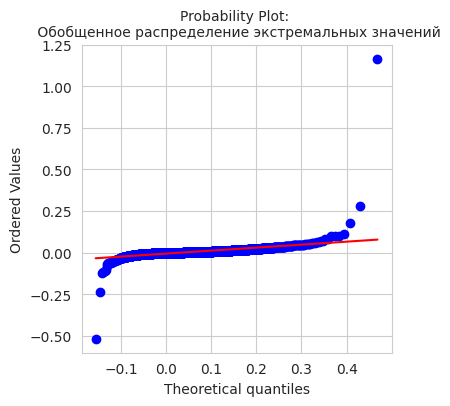

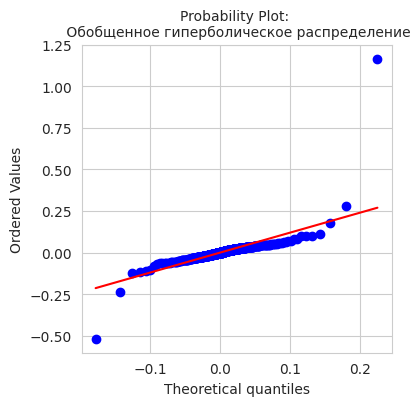

In [38]:
euro.full_info()

### Газпром

In [39]:
stock_gazprom = FinancialInstrument(df=df_price, name='Газпром')

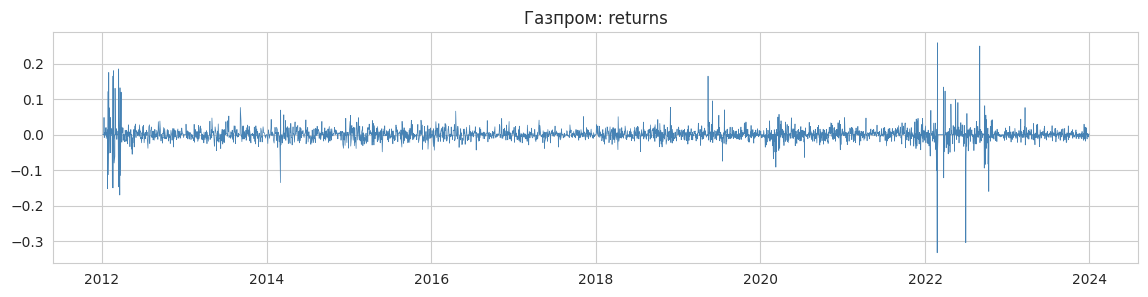

In [40]:
stock_gazprom.returns_dynamics()

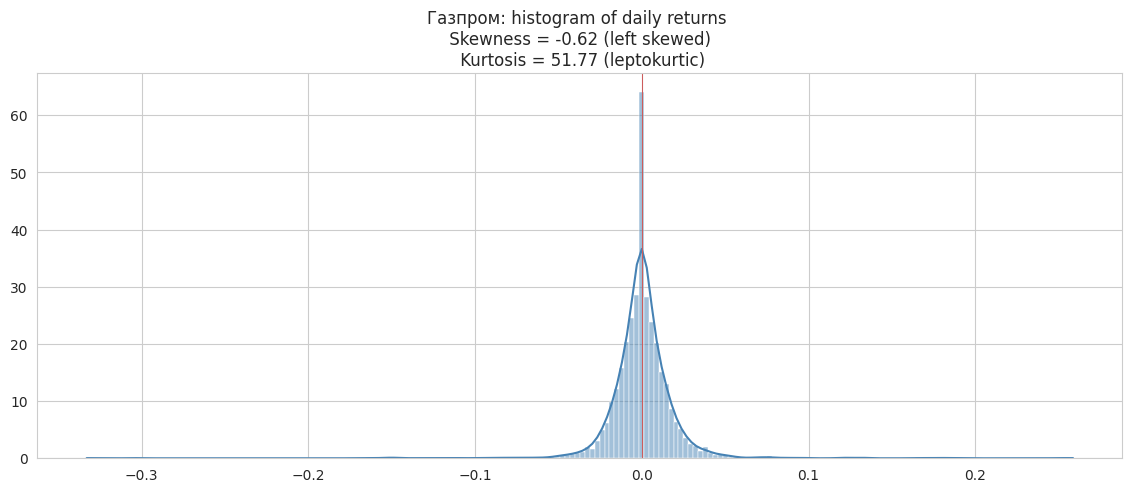

In [41]:
stock_gazprom.histogram(bins=200)

In [47]:
stock_gazprom.hill_estimator(m=15)

Hill estimator
Left tail index: 0.457
Right tail index: 0.5


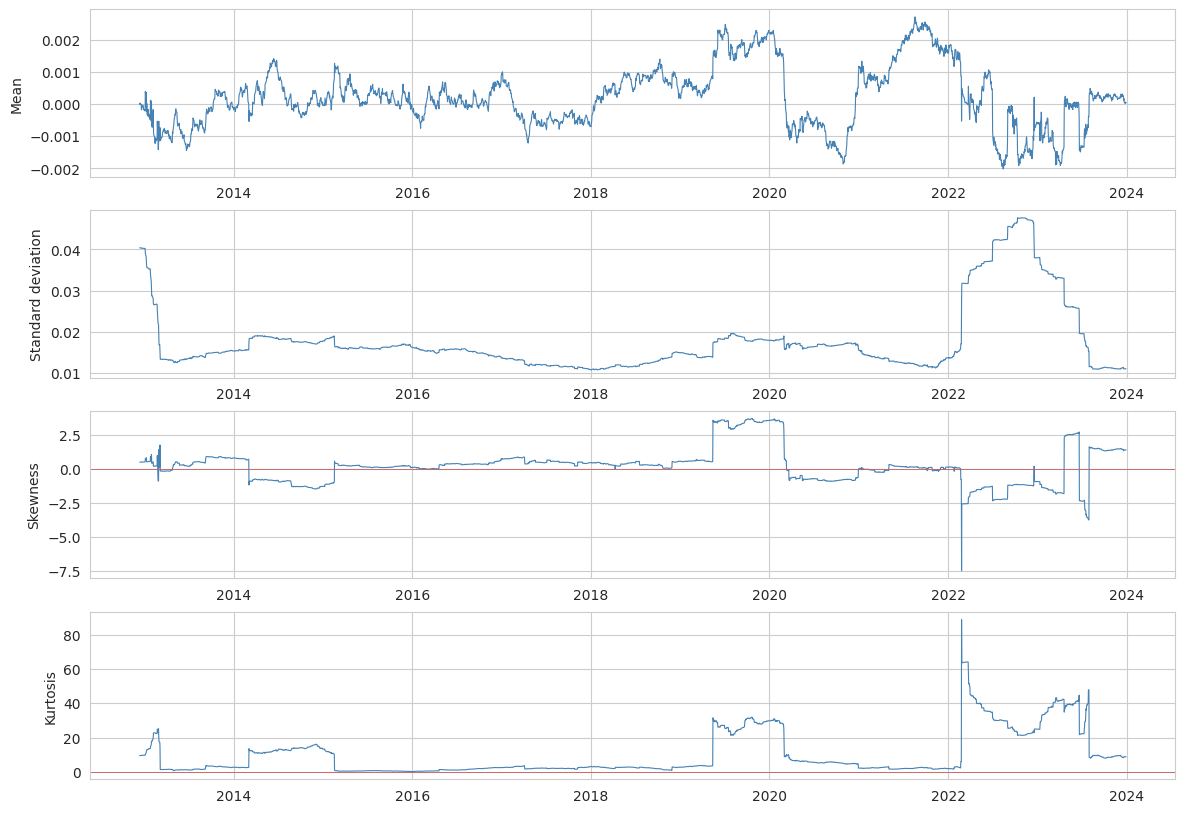

In [48]:
stock_gazprom.get_moving_dynamic(window_size=250)

In [43]:
stock_gazprom.stationarity_test()

Stationarity test
ADF test: the series is stationary.
KPSS test: the series is stationary.


In [44]:
stock_gazprom.ljungbox_test()

Ljung-Box test 
         lb_stat     lb_pvalue comment
1     84.011371  4.919371e-20        
5    104.679803  5.445886e-21        
25   214.003319  6.030893e-32        
50   285.031005  1.218004e-34        
250  509.685205  6.450695e-20        


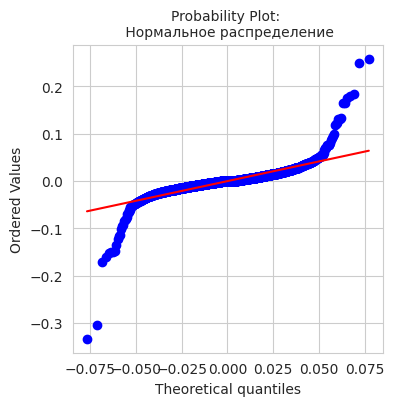

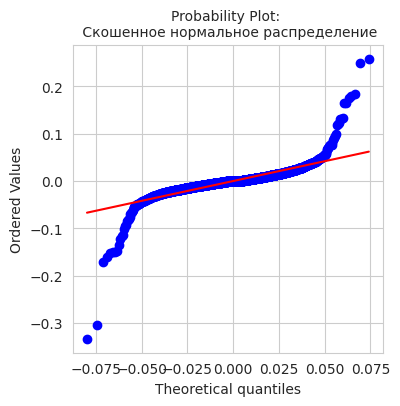

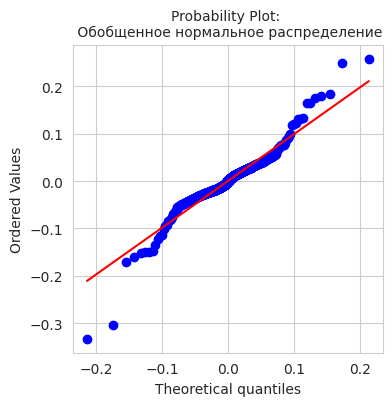

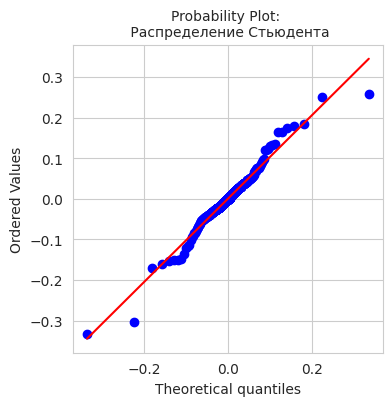

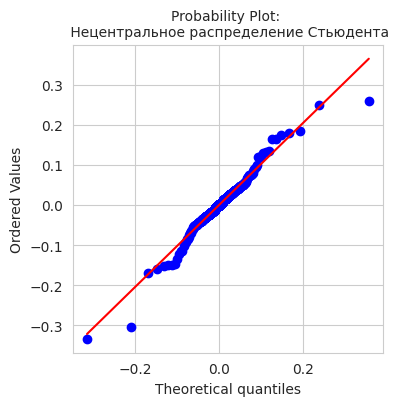

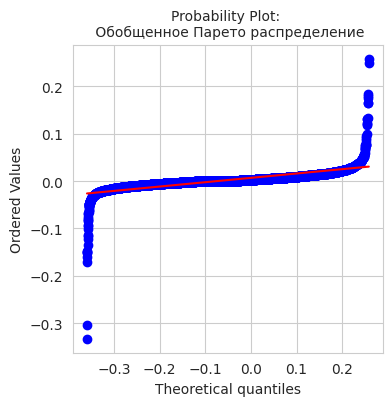

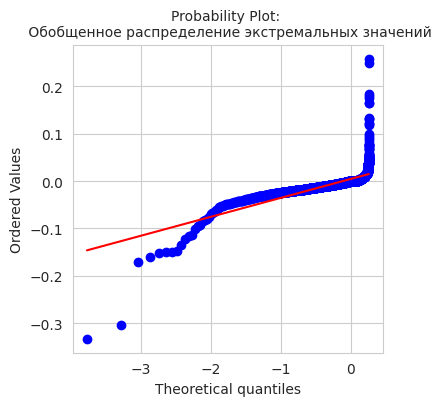

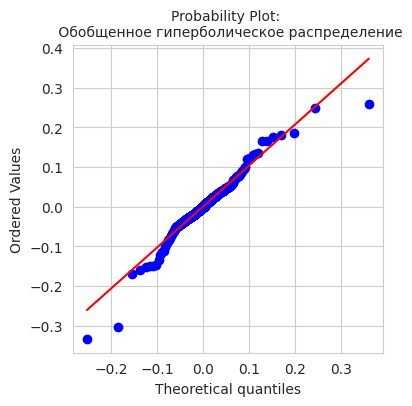

In [45]:
stock_gazprom.qq_plot()